**Projeto de Previsão de Nota de Animes**<br>
Meu primeiro projeto de Machine Learning

Vamos inicialmente baixar as bibliotecas necessarias e importa-las

In [1]:
!pip install pandas matplotlib pyspark scikit-learn -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn import *
from google.colab import files
from sklearn.preprocessing import LabelEncoder

Agora vamos importar nossa base de dados para poder manipula-las e saber mais sobre os animes

In [3]:
df_anime = pd.read_csv("anime.csv")
df_notas = pd.read_csv("rating.csv")

In [4]:
df_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


Vamos dar uma olhada nos dados e tirar o que podemos fazer

In [5]:
df_notas

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Vamos ver a distribuição das notas

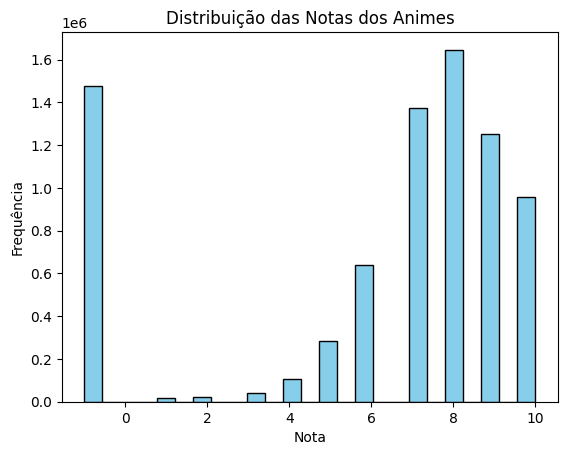

In [6]:
# Criar histograma das notas
plt.hist(df_notas['rating'], bins=25, color='skyblue', edgecolor='black')

# Adicionar título e rótulos aos eixos
plt.title('Distribuição das Notas dos Animes')
plt.xlabel('Nota')
plt.ylabel('Frequência')

# Mostrar
plt.show()

Dessa analise já podemos notar que o site apresenta um limite inferior a zero, podendo dar uma nota negativa, mas o valor de notas não passa de 10

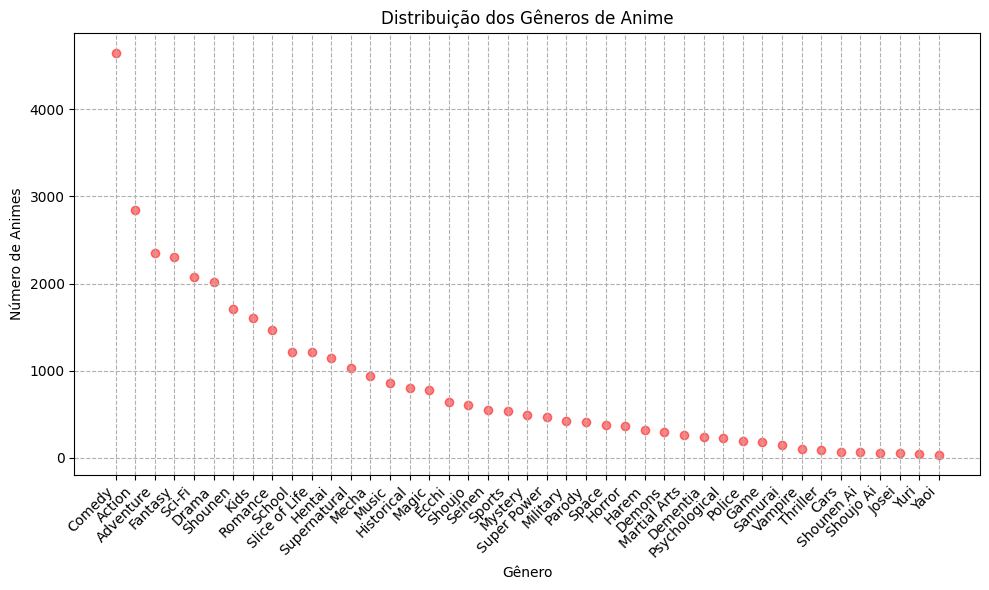

In [7]:
# Contar quantos animes há em cada gênero
genre_counts = df_anime['genre'].str.split(', ').explode().value_counts()

# Agora, vamos criar o gráfico de pontos
plt.figure(figsize=(10, 6))
plt.scatter(genre_counts.index, genre_counts.values, color='red', alpha=0.5)

# Adicionar título e rótulos aos eixos
plt.title('Distribuição dos Gêneros de Anime')
plt.xlabel('Gênero')
plt.ylabel('Número de Animes')

# Rotacionar os rótulos do eixo
plt.xticks(rotation=45, ha='right')

# Fundo xadrez
plt.grid(True, which='both', linestyle='--')

# Exibir
plt.tight_layout()
plt.show()

Podemos ver que a maior quantidade de animes é de comédia e shounen, com os de romances nichados em último

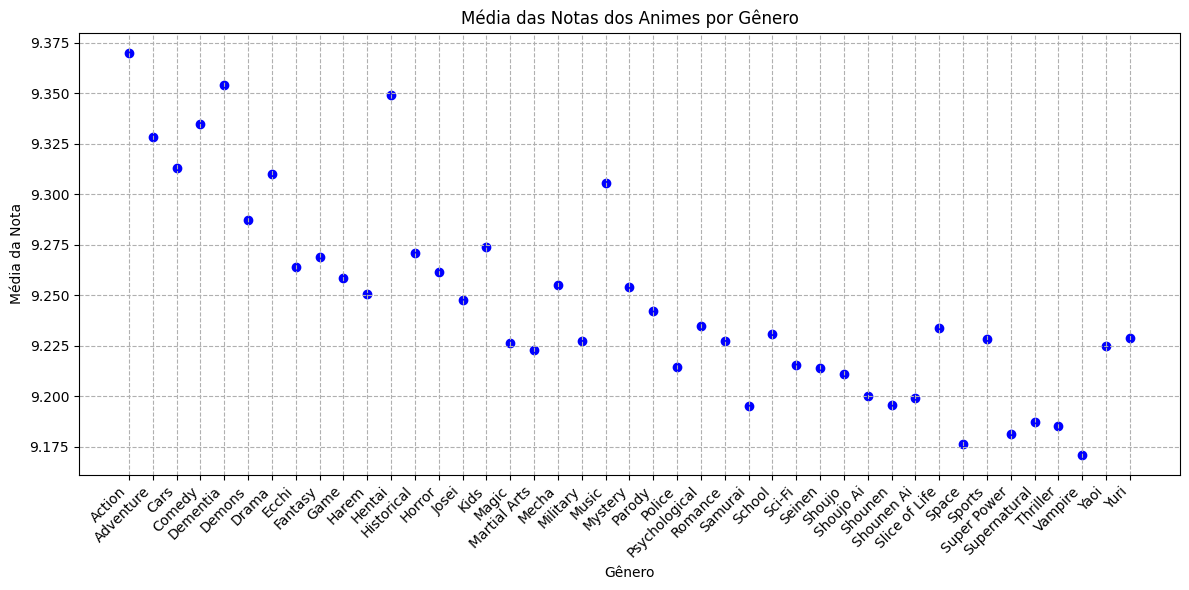

In [8]:
# df com um único gênero por linha
df_genres = df_anime['genre'].str.split(', ', expand=True).stack().reset_index(level=0).rename(columns={0:'genre'})

# Merge os gêneros com as notas
df_merged = pd.merge(df_genres, df_anime[['anime_id', 'rating']], left_index=True, right_index=True)

# Média das notas para cada gênero
df_genre_avg = df_merged.groupby('genre')['rating'].mean().reset_index()

# Gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(df_genre_avg['genre'], df_genre_avg['rating'], color='blue')

# Título e rótulos
plt.title('Média das Notas dos Animes por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Média da Nota')

# Rótulos do eixo x rotacionado
plt.xticks(rotation=45, ha='right')

# Fundo xadrez
plt.grid(True, which='both', linestyle='--')

# Exibir
plt.tight_layout()
plt.show()

Aqui vemos o mais bem avaliado sendo o gênero de ação e o com menos nota sendo o de vampiros

In [9]:
# Sessão do Spark
spark = SparkSession.builder \
    .appName("TopAnimes") \
    .getOrCreate()

# DataFrame
df_anime = spark.read.csv("anime.csv", header=True, inferSchema=True)

# Remover NaN na coluna "rating"
df_anime_cleaned = df_anime.dropna(subset=['rating'])

# Top 10 animes com as melhores notas
top_10_melhores_notas = df_anime.orderBy(df_anime_cleaned["rating"].desc()).limit(10)

# Top 10 animes mais avaliados
top_10_mais_avaliados = df_anime.orderBy(df_anime_cleaned["members"].desc()).limit(10)

# Resultados
print("Top 10 Animes com as Melhores Notas:")
top_10_melhores_notas.show()

print("\nTop 10 Animes Mais Avaliados:")
top_10_mais_avaliados.show()

# Fim da sessão do Spark
spark.stop()


Top 10 Animes com as Melhores Notas:
+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   33662|Taka no Tsume 8: ...|      Comedy, Parody|Movie|       1|  10.0|     13|
|   30120|Spoon-hime no Swi...|     Adventure, Kids|   TV| Unknown|   9.6|     47|
|   23005|    Mogura no Motoro|       Slice of Life|Movie|       1|   9.5|     62|
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|   33607|        Kahei no Umi|          Historical|Movie|       1|  9.33|     44|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|   26313|Yakusoku: Africa ...|         Drama, Kids|  OVA|       1|  9.25|     53|
|    9253|         Steins;Gate|    Sci-Fi, Thrille

Listando acima os melhores e mais avaliados na epoca da base de dados

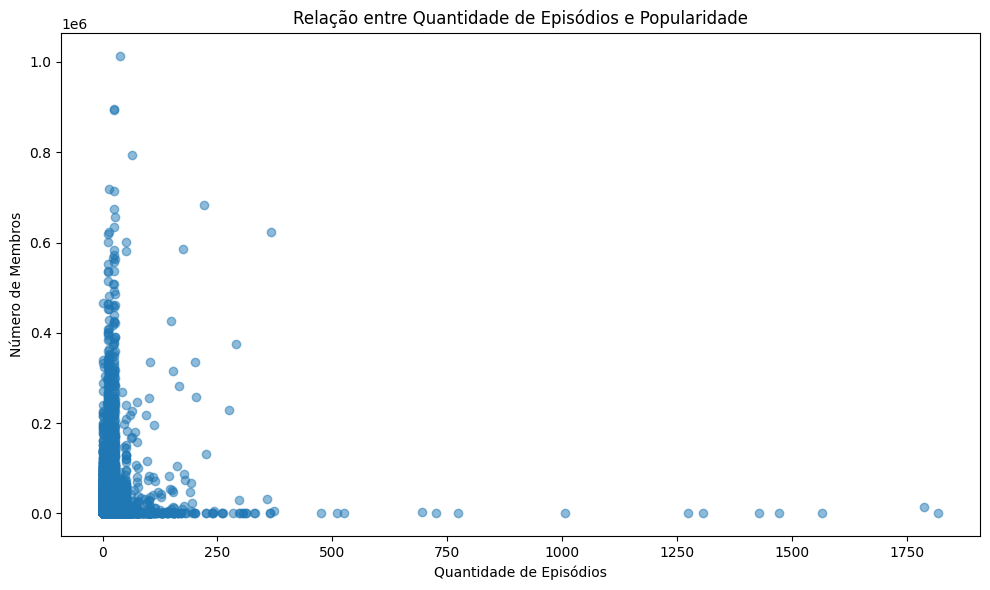

In [10]:
# Sessão do Spark
spark = SparkSession.builder \
    .appName("EpisodesVsPopularity") \
    .getOrCreate()

# df
df_anime = spark.read.csv("anime.csv", header=True, inferSchema=True)

# Remover NaN na coluna "episodes"
df_anime_cleaned = df_anime.dropna(subset=['episodes'])

# 'episodes' para o tipo inteiro
df_anime_cleaned = df_anime_cleaned.withColumn("episodes", df_anime_cleaned["episodes"].cast("int"))

# Gráfico de dispersão
episodes = df_anime_cleaned.select('episodes').collect()
members = df_anime_cleaned.select('members').collect()

plt.figure(figsize=(10, 6))
plt.scatter(episodes, members, alpha=0.5)

# Título e rótulos aos eixos
plt.title('Relação entre Quantidade de Episódios e Popularidade')
plt.xlabel('Quantidade de Episódios')
plt.ylabel('Número de Membros')

# Exiba o gráfico
plt.tight_layout()
plt.show()

Muitos membros não assistem animes mais longos, e aparentemente como tem muitos no 0 provavelmente não colocaram mais informações.

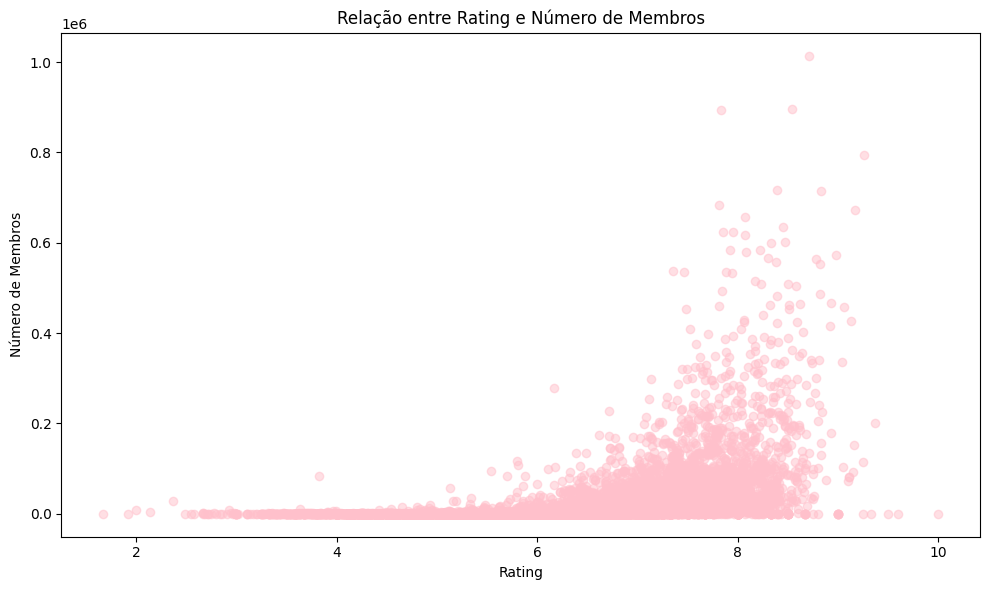

In [11]:
# df
df_anime = pd.read_csv("anime.csv")

# Remover os valores NaN
df_anime_cleaned = df_anime.dropna(subset=['rating', 'members'])

# Definir os dados x e y
x_data = df_anime_cleaned['rating']
y_data = df_anime_cleaned['members']

# Gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, color="pink")

# Adicionar título e rótulos
plt.title('Relação entre Rating e Número de Membros')
plt.xlabel('Rating')
plt.ylabel('Número de Membros')

# Exibir
plt.tight_layout()
plt.show()

Acima é a analise entre votos e nota, podemos ver que tanto as notas minimas quanto maximas tem poucos votos, o que pode pender para um extremo

<ipython-input-12-568325e5aad9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anime['type_encoded'] = le.fit_transform(df_anime['type'])


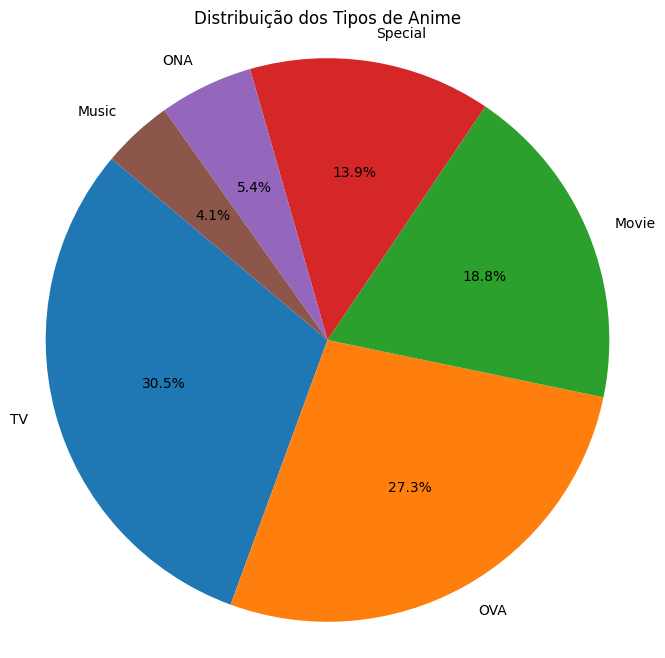

In [12]:
# Tratar valores nulos
df_anime = df_anime.dropna()

# LabelEncoder para codificar os tipos
le = LabelEncoder()

# Codificar os tipos de anime
df_anime['type_encoded'] = le.fit_transform(df_anime['type'])

# Quantidade de cada tipo de anime
type_counts = df_anime['type'].value_counts()

# Rótulos para o gráfico
labels = type_counts.index.tolist()

# Gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=labels, autopct='%1.1f%%', startangle=140)

# Título
plt.title('Distribuição dos Tipos de Anime')

# Gráfico
plt.axis('equal')
plt.show()



Podemos ver aqui que os animes normais que passam na TV, tanto os normais quanto os OVA somam 57.8%

Vamos fazer uma *Analise de Correlação*

In [13]:
# Calcular o coeficiente de correlação de Pearson entre 'rating' e 'members'
correlation = df_anime_cleaned['rating'].corr(df_anime_cleaned['members'])

# Exibir o resultado
print("Coeficiente de Correlação entre Rating e Número de Membros:", correlation)

Coeficiente de Correlação entre Rating e Número de Membros: 0.3879794585003166


Essa correlção sugere que os otakus são bem críticos com os animes não dando geralmente uma nota no meio, geralmente é menos de 5

Vou tentar fazer um pouco de ***MACHINE LEARNING***
Com esse objetivo:<br>
**Previsão de Classificação de Animes**: Treinar um modelo de regressão para prever a classificação (rating) de um anime com base em características como gênero, número de episódios, etc.

**Pré-Processamento de Dados**

In [14]:
# Carregar os dados dos animes
df_anime = pd.read_csv("anime.csv")

# Verificar valores ausentes
print("Valores Ausentes por Coluna:")
print(df_anime.isnull().sum())

# Remover linhas com valores ausentes
df_anime_cleaned = df_anime.dropna(subset=['genre'])
df_anime_cleaned = df_anime_cleaned[df_anime_cleaned['episodes'] != 'Unknown']

# Converter a coluna 'episodes' para int
df_anime_cleaned['episodes'] = df_anime_cleaned['episodes'].astype(int)

# Remover coluna 'name'
df_anime_cleaned = df_anime_cleaned.drop(columns=['name'])

# Converter gêneros para colunas binárias
genres = df_anime_cleaned['genre'].str.get_dummies(sep=', ')
df_anime_cleaned = pd.concat([df_anime_cleaned, genres], axis=1)

# Verificar valores mínimos e máximos
print("Valores Mínimos por Coluna:")
print(df_anime_cleaned.min())

print("\nValores Máximos por Coluna:")
print(df_anime_cleaned.max())

# Finalização
print("\nDados Pré-processados:")
print(df_anime_cleaned.head())

Valores Ausentes por Coluna:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
Valores Mínimos por Coluna:
anime_id              1
genre            Action
type              Movie
episodes              1
rating             1.67
members               5
Action                0
Adventure             0
Cars                  0
Comedy                0
Dementia              0
Demons                0
Drama                 0
Ecchi                 0
Fantasy               0
Game                  0
Harem                 0
Hentai                0
Historical            0
Horror                0
Josei                 0
Kids                  0
Magic                 0
Martial Arts          0
Mecha                 0
Military              0
Music                 0
Mystery               0
Parody                0
Police                0
Psychological         0
Romance               0
Samurai               0
School                0
Sc

In [15]:
# Inicializando a sessão Spark
spark = SparkSession.builder \
    .appName("AnimeRatingPrediction") \
    .getOrCreate()

unique_genres = df_anime_cleaned['genre'].str.split(', ').explode().unique()
print("Gêneros Disponíveis:")
print(unique_genres)

# Imprimir todos os gêneros no DataFrame
print("\nGêneros no DataFrame:")
print(df_anime_cleaned['genre'].str.split(', ').explode().tolist())

Gêneros Disponíveis:
['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'Super Power' 'Space' 'Slice of Life'
 'Mecha' 'Music' 'Mystery' 'Seinen' 'Martial Arts' 'Vampire' 'Shoujo'
 'Horror' 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'Shounen Ai'
 'Game' 'Dementia' 'Harem' 'Cars' 'Kids' 'Shoujo Ai' 'Hentai' 'Yaoi'
 'Yuri']

Gêneros no DataFrame:
['Drama', 'Romance', 'School', 'Supernatural', 'Action', 'Adventure', 'Drama', 'Fantasy', 'Magic', 'Military', 'Shounen', 'Action', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Shounen', 'Sci-Fi', 'Thriller', 'Action', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Shounen', 'Comedy', 'Drama', 'School', 'Shounen', 'Sports', 'Action', 'Adventure', 'Shounen', 'Super Power', 'Drama', 'Military', 'Sci-Fi', 'Space', 'Action', 'Comedy', 'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Shounen', 'Action', '

**Engenharia de Características & Treino e Teste**

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, rand

# Inicialização da sessão Spark
spark = SparkSession.builder.getOrCreate()

# Convertendo o DataFrame do Pandas em um DataFrame do Spark
df_anime_cleaned_spark = spark.createDataFrame(df_anime_cleaned)

# Selecionando uma amostra aleatória
df_anime_sample = df_anime_cleaned_spark.orderBy(rand()).limit(1000)

# Definindo as features e target
feature_columns = ['episodes', 'members']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_data = assembler.transform(df_anime_sample).select("features", "rating")

# Removendo linhas com valores nulos ou NaNs
final_data = final_data.dropna()

# Dividindo o conjunto de dados em treinamento e teste
(train_data, test_data) = final_data.randomSplit([0.8, 0.2], seed=42)

# Regressão linear
lr = LinearRegression(featuresCol='features', labelCol='rating')

# Treinando o modelo e avaliando sua performance
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

# Avaliando o desempenho do modelo
evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Imprimindo o desempenho do modelo
print("Desempenho do Modelo:")
print(f"RMSE: {rmse}")

Desempenho do Modelo:
RMSE: 0.8671333584492896


Aqui faremos o teste para ver como a predição de notas se sai com um <br>
***Input Prático***

### **Exemplo de Input para Análise de Anime**

#### **Gêneros Disponíveis:**
Drama, Romance, School, Supernatural, Action, Adventure, Fantasy, Magic, Military, Shounen, Comedy, Historical, Parody, Samurai, Sci-Fi, Thriller, Sports, Super Power, Space, Slice of Life, Mecha, Music, Mystery, Seinen, Martial Arts, Vampire, Shoujo, Horror, Police, Psychological, Demons, Ecchi, Josei, Shounen Ai, Game, Dementia, Harem, Cars, Kids, Shoujo Ai, Hentai, Yaoi, Yuri

#### **Tipos de Anime Disponíveis:**
Movie, TV, OVA, Special, ONA, Music

#### **Exemplo de Input:**
Para analisar um anime, você pode fornecer as seguintes informações:

- Número de episódios: 12
- Gêneros: Drama, Romance, School
- Tipo: TV

Darei mais uma pequena repaginada na máquina

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Codificando a coluna 'type' usando LabelEncoder
label_encoder = LabelEncoder()
df_anime_cleaned['type_encoded'] = label_encoder.fit_transform(df_anime_cleaned['type'])

# Definindo as features e o target
feature_columns = ['episodes', 'members', 'type_encoded'] + list(df_anime_cleaned.columns[6:])
X = df_anime_cleaned[feature_columns]
y = df_anime_cleaned['rating']

# Removendo linhas com valores NaN no target
X = X.dropna()
y = y.dropna()

# Pegando uma amostra do mesmo tamanho
y_indices = y.index
X = X.loc[y_indices]

# Separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializando e treinando
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Fazendo a previsão usando o modelo treinado
predicted_rating = lr_model.predict(X_test)

# Exibindo a previsão
print("Pontuação prevista para os animes de teste:", predicted_rating)


Pontuação prevista para os animes de teste: [6.22212379 7.51072916 6.6220351  ... 6.55314612 6.15729299 6.09708216]


Aqui abaixo tirando o código de warning pra ficar mais visualmente bonito

In [18]:
import warnings
warnings.simplefilter(action='ignore')

Agora aqui você pode se sentir livre para testar a previsão da nota de um anime com quaisquer caracteristicas que você imaginar


In [20]:
# Solicitando input
episodes_input = int(input("Insira o número de episódios do anime: "))
members_input = int(input("Insira o número de usuários do anime: "))
anime_type_input = input("Insira o tipo do anime (ex: TV, Movie, OVA, etc.): ")
genre_input = input("Insira o gênero do anime (ex: Action, Adventure, Comedy, etc.): ")

# Convertendo anime para o formato codificado
anime_type_encoded = label_encoder.transform([anime_type_input])[0]

# Exemplo de entrada com as informações fornecidas pelo usuário
example_input = np.zeros(len(feature_columns))
example_input[0] = episodes_input
example_input[1] = members_input
example_input[2] = anime_type_encoded

# Verificando se gênero fornecido é existente
if genre_input in df_anime_cleaned.columns:
    genre_index = df_anime_cleaned.columns.get_loc(genre_input)
    example_input[genre_index] = 1  # Gênero fornecido pelo usuário como 1

# Fazendo a previsão usando o modelo treinado
predicted_rating = lr_model.predict([example_input])

# Exibindo a previsão
print("Pontuação prevista para o anime inserido: {:.2f}".format(predicted_rating[0]))

Insira o número de episódios do anime: 25
Insira o número de usuários do anime: 2490
Insira o tipo do anime (ex: TV, Movie, OVA, etc.): TV
Insira o gênero do anime (ex: Action, Adventure, Comedy, etc.): Action, Adventure, Comedy
Pontuação prevista para o anime inserido: 5.93
